<a href="https://colab.research.google.com/github/amanu242006/FAC-task-3/blob/main/FAC_task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile
import os

# Path to the ZIP file
zip_path = "/content/OptionBacktest2023.zip"

# Get the base name (folder name) from the ZIP file name
zip_name = os.path.splitext(os.path.basename(zip_path))[0]
extract_path = os.path.join("/content", zip_name)  # MUST be in /content to see in file explorer

# Create the folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file into the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)


✅ Extracted to: /content/OptionBacktest2023


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [5]:
df_spot=pd.read_csv("/tmp/OptionBacktest2023/OptionBacktest2023/NIFTY2023/NIFTY_cash.csv")

In [6]:
df_spot

,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count
0,2023-01-02 07:53:00,NIFTY,NSE,NaN,NaN,NaN,NaN,18105.3,18105.3,18105.3,18105.3,NaN,NaN,0
1,2023-01-02 07:54:00,NIFTY,NSE,NaN,NaN,NaN,NaN,18105.3,18105.3,18105.3,18105.3,NaN,NaN,1
2,2023-01-02 07:55:00,NIFTY,NSE,NaN,NaN,NaN,NaN,18105.3,18105.3,18105.3,18105.3,NaN,NaN,2
3,2023-01-02 07:56:00,NIFTY,NSE,NaN,NaN,NaN,NaN,18105.3,18105.3,18105.3,18105.3,NaN,NaN,3
4,2023-01-02 07:57:00,NIFTY,NSE,NaN,NaN,NaN,NaN,18105.3,18105.3,18105.3,18105.3,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132625,2024-01-01 15:58:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21741.9,21741.9,21741.9,21741.9,NaN,NaN,132625
132626,2024-01-01 15:59:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21741.9,21741.9,21741.9,21741.9,NaN,NaN,132626
132627,2024-01-01 16:00:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21741.9,21741.9,21741.9,21741.9,NaN,NaN,132627
132628,2024-01-01 16:01:00,NIFTY,NSE,NaN,NaN,NaN,NaN,21741.9,21741.9,21741.9,21741.9,NaN,NaN,132628


In [7]:
df_spot=df_spot[["datetime","open","high","low","close","count"]]

In [8]:
df_spot

,datetime,open,high,low,close,count
0,2023-01-02 07:53:00,18105.3,18105.3,18105.3,18105.3,0
1,2023-01-02 07:54:00,18105.3,18105.3,18105.3,18105.3,1
2,2023-01-02 07:55:00,18105.3,18105.3,18105.3,18105.3,2
3,2023-01-02 07:56:00,18105.3,18105.3,18105.3,18105.3,3
4,2023-01-02 07:57:00,18105.3,18105.3,18105.3,18105.3,4
...,...,...,...,...,...,...
132625,2024-01-01 15:58:00,21741.9,21741.9,21741.9,21741.9,132625
132626,2024-01-01 15:59:00,21741.9,21741.9,21741.9,21741.9,132626
132627,2024-01-01 16:00:00,21741.9,21741.9,21741.9,21741.9,132627
132628,2024-01-01 16:01:00,21741.9,21741.9,21741.9,21741.9,132628


In [9]:
df_spot["datetime"]=pd.to_datetime(df_spot["datetime"])




/tmp/ipython-input-9-2535898237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spot["datetime"]=pd.to_datetime(df_spot["datetime"])


In [19]:
df_spot.set_index("datetime")

,open,high,low,close,count
datetime,,,,,
2023-01-02 07:53:00,18105.3,18105.3,18105.3,18105.3,0
2023-01-02 07:54:00,18105.3,18105.3,18105.3,18105.3,1
2023-01-02 07:55:00,18105.3,18105.3,18105.3,18105.3,2
2023-01-02 07:56:00,18105.3,18105.3,18105.3,18105.3,3
2023-01-02 07:57:00,18105.3,18105.3,18105.3,18105.3,4
...,...,...,...,...,...
2024-01-01 15:58:00,21741.9,21741.9,21741.9,21741.9,132625
2024-01-01 15:59:00,21741.9,21741.9,21741.9,21741.9,132626
2024-01-01 16:00:00,21741.9,21741.9,21741.9,21741.9,132627


In [10]:
def compute_indicators(df, atr_window=14):
    df = df.copy()
    df['prev_close'] = df['close'].shift(1)
    df['H-L'] = abs(df['high'] - df['low'])
    df['H-PC'] = abs(df['high'] - df['prev_close'])
    df['L-PC'] = abs(df['low'] - df['prev_close'])
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    return df.drop(columns=['prev_close', 'H-L', 'H-PC', 'L-PC', 'TR'])


In [11]:
  df_spot=compute_indicators(df_spot)

In [12]:
df_spot.head(100)

,datetime,open,high,low,close,count,ATR
0,2023-01-02 07:53:00,18105.30,18105.30,18105.30,18105.30,0,NaN
1,2023-01-02 07:54:00,18105.30,18105.30,18105.30,18105.30,1,NaN
2,2023-01-02 07:55:00,18105.30,18105.30,18105.30,18105.30,2,NaN
3,2023-01-02 07:56:00,18105.30,18105.30,18105.30,18105.30,3,NaN
4,2023-01-02 07:57:00,18105.30,18105.30,18105.30,18105.30,4,NaN
...,...,...,...,...,...,...,...
95,2023-01-02 09:28:00,18108.70,18114.30,18104.00,18108.50,95,18.503571
96,2023-01-02 09:29:00,18108.05,18108.05,18092.40,18098.15,96,17.325000
97,2023-01-02 09:30:00,18099.00,18111.20,18095.30,18111.20,97,17.103571
98,2023-01-02 09:31:00,18110.45,18111.55,18087.55,18092.85,98,17.200000


In [13]:
df_spot['ATR_MA'] = df_spot['ATR'].rolling(window=14).mean()


In [14]:
df_spot['Time'] = df_spot['datetime'].dt.time

In [15]:
df_spot['Signal'] = (df_spot['ATR'] > df_spot['ATR_MA']).astype(int)

In [16]:
df_spot

,datetime,open,high,low,close,count,ATR,ATR_MA,Time,Signal
0,2023-01-02 07:53:00,18105.3,18105.3,18105.3,18105.3,0,NaN,NaN,07:53:00,0
1,2023-01-02 07:54:00,18105.3,18105.3,18105.3,18105.3,1,NaN,NaN,07:54:00,0
2,2023-01-02 07:55:00,18105.3,18105.3,18105.3,18105.3,2,NaN,NaN,07:55:00,0
3,2023-01-02 07:56:00,18105.3,18105.3,18105.3,18105.3,3,NaN,NaN,07:56:00,0
4,2023-01-02 07:57:00,18105.3,18105.3,18105.3,18105.3,4,NaN,NaN,07:57:00,0
...,...,...,...,...,...,...,...,...,...,...
132625,2024-01-01 15:58:00,21741.9,21741.9,21741.9,21741.9,132625,0.0,0.865561,15:58:00,0
132626,2024-01-01 15:59:00,21741.9,21741.9,21741.9,21741.9,132626,0.0,0.288520,15:59:00,0
132627,2024-01-01 16:00:00,21741.9,21741.9,21741.9,21741.9,132627,0.0,0.000000,16:00:00,0
132628,2024-01-01 16:01:00,21741.9,21741.9,21741.9,21741.9,132628,0.0,0.000000,16:01:00,0


In [17]:
df_spot.dropna(inplace=True)

In [18]:
def estimate_strike(price, step=100):
    return (price // step) * step

df_spot['ATM_Strike'] = np.where(
    df_spot['Signal'] == 1,
    df_spot['close'].map(lambda price: estimate_strike(price, 100)),
    np.nan
)



In [19]:
df_spot['ATM_Strike'] = df_spot['ATM_Strike'].ffill()

In [20]:
df_spot.head(1000)

,datetime,open,high,low,close,count,ATR,ATR_MA,Time,Signal,ATM_Strike
26,2023-01-02 08:19:00,18105.30,18105.30,18105.30,18105.30,26,0.0,0.0,08:19:00,0,NaN
27,2023-01-02 08:20:00,18105.30,18105.30,18105.30,18105.30,27,0.0,0.0,08:20:00,0,NaN
28,2023-01-02 08:21:00,18105.30,18105.30,18105.30,18105.30,28,0.0,0.0,08:21:00,0,NaN
29,2023-01-02 08:22:00,18105.30,18105.30,18105.30,18105.30,29,0.0,0.0,08:22:00,0,NaN
30,2023-01-02 08:23:00,18105.30,18105.30,18105.30,18105.30,30,0.0,0.0,08:23:00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1021,2023-01-04 07:50:00,18232.55,18232.55,18232.55,18232.55,1021,0.0,0.0,07:50:00,0,18200.0
1022,2023-01-04 07:51:00,18232.55,18232.55,18232.55,18232.55,1022,0.0,0.0,07:51:00,0,18200.0
1023,2023-01-04 07:52:00,18232.55,18232.55,18232.55,18232.55,1023,0.0,0.0,07:52:00,0,18200.0
1024,2023-01-04 07:53:00,18232.55,18232.55,18232.55,18232.55,1024,0.0,0.0,07:53:00,0,18200.0


In [21]:
df_spot.dropna(inplace=True)

In [22]:
len(df_spot)

132563

In [23]:
month_map = {
    1: '01Jan', 2: '02Feb', 3: '03Mar', 4: '04Apr',
    5: '05May', 6: '06Jun', 7: '07Jul', 8: '08Aug',
    9: '09Sep', 10: '10Oct', 11: '11Nov', 12: '12Dec'
}


In [24]:
pip install tqdm

In [25]:
from tqdm import tqdm

In [26]:
df_spot.head(100)

,datetime,open,high,low,close,count,ATR,ATR_MA,Time,Signal,ATM_Strike
67,2023-01-02 09:00:00,18105.30,18222.20,18105.30,18168.95,67,8.350000,0.596429,09:00:00,1,18100.0
68,2023-01-02 09:01:00,18136.70,18155.70,18136.70,18151.95,68,10.653571,1.357398,09:01:00,1,18100.0
69,2023-01-02 09:02:00,18151.90,18151.90,18138.85,18139.45,69,11.589286,2.185204,09:02:00,1,18100.0
70,2023-01-02 09:03:00,18139.55,18141.70,18129.60,18134.00,70,12.453571,3.074745,09:03:00,1,18100.0
71,2023-01-02 09:04:00,18134.00,18139.65,18133.60,18139.65,71,12.885714,3.995153,09:04:00,1,18100.0
...,...,...,...,...,...,...,...,...,...,...,...
162,2023-01-02 10:35:00,18165.95,18166.70,18162.85,18165.55,162,5.210714,4.800000,10:35:00,1,18100.0
163,2023-01-02 10:36:00,18165.50,18168.10,18163.40,18166.10,163,5.310714,4.816582,10:36:00,1,18100.0
164,2023-01-02 10:37:00,18164.75,18175.00,18164.75,18175.00,164,5.725000,4.888010,10:37:00,1,18100.0
165,2023-01-02 10:38:00,18175.00,18183.10,18173.30,18181.50,165,6.207143,5.002806,10:38:00,1,18100.0


In [27]:

#  Config
expiry_map = {
    "01Jan": "2023-01-25",
    "02Feb": "2023-02-23",
    "03Mar": "2023-03-29",
    "04Apr": "2023-04-27",
    "05May": "2023-05-25",
    "06Jun": "2023-06-28",
    "07Jul": "2023-07-27",
    "08Aug": "2023-08-31",
    "09Sep": "2023-09-28",
    "10Oct": "2023-10-26",
    "11Nov": "2023-11-30",
    "12Dec": "2023-12-28"
}

month_map = {
    1: '01Jan', 2: '02Feb', 3: '03Mar', 4: '04Apr',
    5: '05May', 6: '06Jun', 7: '07Jul', 8: '08Aug',
    9: '09Sep', 10: '10Oct', 11: '11Nov', 12: '12Dec'
}

def round_to_strike(price, interval=100):
    return int(round(price / interval) * interval)


In [28]:
#  Initialize Variables
nifty_df = df_spot  # This has columns: datetime, close, Signal
base_path = "/content/OptionBacktest2023/OptionBacktest2023"
initial_capital = 100000
capital = initial_capital
capital_per_trade = 10000
lot_size = 50

pnl_list = []
capital_series = []
win_trades = 0
trade_log = []
option_cache = {}
in_trade = False

# Trade state variables
current_trade = {
    "signal_time": None,
    "strike": None,
    "expiry_date_str": None,
    "ce_price_entry": None,
    "pe_price_entry": None,
    "entry_nifty": None,
    "num_lots": None,
    "entry_cost": None,
    "ce_df": None,
    "pe_df": None
}

capital_list=[]


In [29]:
import os


# Backtest
for i, row in tqdm(nifty_df.iterrows(), total=len(nifty_df)):
    current_time = row["datetime"]
    capital_list.append(capital)

    # Entry condition: Signal occurs and not in trade
    if row["Signal"] and not in_trade:
        signal_time = pd.to_datetime(row["datetime"])
        strike = round_to_strike(row["close"])
        month_key = month_map[signal_time.month]
        expiry_date_str = expiry_map[month_key]
        expiry_folder = f"{month_key}-Nifty"

        # Prepare filenames
        expiry_dt = pd.to_datetime(expiry_date_str)
        ce_filename = f"{strike}_call_{expiry_dt.strftime('%Y-%m-%d').upper()}.csv"
        pe_filename = f"{strike}_put_{expiry_dt.strftime('%Y-%m-%d').upper()}.csv"

        # Load data
        ce_path = os.path.join(base_path, expiry_folder, ce_filename)
        pe_path = os.path.join(base_path, expiry_folder, pe_filename)

        try:
            # Load data if not cached
            if ce_path not in option_cache:
                ce_df = pd.read_csv(ce_path)
                ce_df['datetime'] = pd.to_datetime(ce_df['datetime'])
                option_cache[ce_path] = ce_df
            else:
                ce_df = option_cache[ce_path]

            if pe_path not in option_cache:
                pe_df = pd.read_csv(pe_path)
                pe_df['datetime'] = pd.to_datetime(pe_df['datetime'])
                option_cache[pe_path] = pe_df
            else:
                pe_df = option_cache[pe_path]

            # Get entry prices
            ce_entry = ce_df[ce_df["datetime"] == signal_time]
            pe_entry = pe_df[pe_df["datetime"] == signal_time]

            if ce_entry.empty or pe_entry.empty:
                continue

            ce_price_entry = ce_entry["close"].values[0]
            pe_price_entry = pe_entry["close"].values[0]

            # Calculate position size
            entry_cost = (ce_price_entry + pe_price_entry) * lot_size
            num_lots = int(capital_per_trade // entry_cost)
            trade_cost = entry_cost * num_lots
            if(num_lots==0):
                continue

            # Update trade state
            current_trade = {
                "signal_time": signal_time,
                "strike": strike,
                "expiry_date_str": expiry_date_str,
                "ce_price_entry": ce_price_entry,
                "pe_price_entry": pe_price_entry,
                "entry_nifty": row["close"],
                "num_lots": num_lots,
                "entry_cost": trade_cost,
                "ce_df": ce_df,
                "pe_df": pe_df
            }
            in_trade = True
            print(f"Entered trade at {signal_time}: Strike {strike}, Lots {num_lots}")

        except Exception as e:
            print(f"Trade entry failed: {str(e)}")
            continue

    # Exit conditions (only when in trade)
    if in_trade:
        # 1. Mandatory expiry exit
        expiry_date = pd.to_datetime(current_trade["expiry_date_str"]).date()
        if current_time.date() == expiry_date and current_time.time() >= pd.Timestamp("15:15:00").time():
            try:
                ce_exit = current_trade["ce_df"][
                    (current_trade["ce_df"]["datetime"].dt.date == expiry_date) &
                    (current_trade["ce_df"]["datetime"].dt.time == pd.Timestamp("15:15:00").time())
                ]
                pe_exit = current_trade["pe_df"][
                    (current_trade["pe_df"]["datetime"].dt.date == expiry_date) &
                    (current_trade["pe_df"]["datetime"].dt.time == pd.Timestamp("15:15:00").time())
                ]

                if not ce_exit.empty and not pe_exit.empty:
                    ce_price_exit = ce_exit["close"].values[0]
                    pe_price_exit = pe_exit["close"].values[0]
                    exit_reason = "Expiry"
            except:
                # Fallback to last available price
                ce_price_exit = current_trade["ce_df"]["close"].iloc[-1]
                pe_price_exit = current_trade["pe_df"]["close"].iloc[-1]
                exit_reason = "Expiry (Fallback)"

        # 2. Only keep profit-taking exit (removed stop-loss)
        else:
            try:
                ce_price_now = current_trade["ce_df"][current_trade["ce_df"]["datetime"] == current_time]["close"].values[0]
                pe_price_now = current_trade["pe_df"][current_trade["pe_df"]["datetime"] == current_time]["close"].values[0]

                current_value = (ce_price_now + pe_price_now) * lot_size * current_trade["num_lots"]
                return_pct = (current_value - current_trade["entry_cost"]) / current_trade["entry_cost"]

                # Take profit only (no stop-loss)
                if return_pct >= 0.25:  # Increased to 25% profit
                    ce_price_exit = ce_price_now
                    pe_price_exit = pe_price_now
                    exit_reason = "Profit Take"
                else:
                    # No exit condition met
                    continue
            except:
                continue

        # Calculate final PnL if exited
        exit_value = (ce_price_exit + pe_price_exit) * lot_size * current_trade["num_lots"]
        trade_pnl = exit_value - current_trade["entry_cost"]

        # Update capital
        capital += trade_pnl
        pnl_list.append(trade_pnl)
        if trade_pnl > 0:
            win_trades += 1

        # Log trade
        trade_log.append({
            "entry_time": current_trade["signal_time"],
            "exit_time": current_time,
            "exit_reason": exit_reason,
            "strike": current_trade["strike"],
            "entry_nifty": current_trade["entry_nifty"],
            "exit_nifty": row["close"],
            "ce_entry": current_trade["ce_price_entry"],
            "pe_entry": current_trade["pe_price_entry"],
            "ce_exit": ce_price_exit,
            "pe_exit": pe_price_exit,
            "num_lots": current_trade["num_lots"],
            "pnl": trade_pnl,
            "capital": capital
        })

        print(f"Exited trade: {exit_reason} | P&L: {trade_pnl:.2f}")
        in_trade = False

  5%|▌         | 7124/132563 [00:05<01:38, 1269.05it/s]

Entered trade at 2023-01-20 09:26:00: Strike 18100, Lots 1


  7%|▋         | 9122/132563 [00:08<02:58, 690.63it/s]

Exited trade: Profit Take | P&L: 2557.50
Entered trade at 2023-01-25 11:41:00: Strike 17900, Lots 2


  7%|▋         | 9776/132563 [00:09<01:40, 1225.02it/s]

Exited trade: Expiry | P&L: -6530.00
Entered trade at 2023-01-25 15:28:00: Strike 17900, Lots 25
Exited trade: Expiry | P&L: 3000.00
Entered trade at 2023-01-25 15:29:00: Strike 17900, Lots 24
Exited trade: Expiry | P&L: 2700.00
Entered trade at 2023-01-25 15:29:00: Strike 17900, Lots 24
Exited trade: Expiry | P&L: 2700.00
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest202

  8%|▊         | 10326/132563 [00:09<01:17, 1569.63it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'


  8%|▊         | 10793/132563 [00:09<01:07, 1800.55it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'

  8%|▊         | 11166/132563 [00:10<01:11, 1695.64it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/17700_put_2023-01-25.csv'

 13%|█▎        | 17113/132563 [00:13<01:29, 1291.37it/s]

Entered trade at 2023-02-16 15:00:00: Strike 18100, Lots 1


 13%|█▎        | 17679/132563 [00:14<02:06, 907.31it/s]

Exited trade: Profit Take | P&L: 2537.50
Entered trade at 2023-02-17 15:05:00: Strike 17900, Lots 1


 14%|█▍        | 18937/132563 [00:16<02:32, 746.09it/s]

Exited trade: Profit Take | P&L: 2627.50
Entered trade at 2023-02-22 10:56:00: Strike 17700, Lots 1


 14%|█▍        | 19086/132563 [00:16<02:49, 667.98it/s]

Exited trade: Profit Take | P&L: 1622.50
Entered trade at 2023-02-22 13:30:00: Strike 17600, Lots 1


 15%|█▍        | 19815/132563 [00:17<01:52, 1003.20it/s]

Exited trade: Expiry | P&L: -1592.50


 23%|██▎       | 30394/132563 [00:24<01:03, 1609.82it/s]

Entered trade at 2023-03-27 09:26:00: Strike 17000, Lots 1


 24%|██▍       | 32219/132563 [00:27<03:05, 540.44it/s]

Exited trade: Expiry | P&L: -5807.50
Entered trade at 2023-03-29 15:26:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1457.50
Entered trade at 2023-03-29 15:26:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1457.50
Entered trade at 2023-03-29 15:27:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1457.50
Entered trade at 2023-03-29 15:27:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1457.50
Entered trade at 2023-03-29 15:28:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1045.00
Entered trade at 2023-03-29 15:28:00: Strike 17100, Lots 11
Exited trade: Expiry | P&L: 1045.00
Entered trade at 2023-03-29 15:29:00: Strike 17100, Lots 10
Exited trade: Expiry | P&L: 425.00
Entered trade at 2023-03-29 15:29:00: Strike 17100, Lots 10
Exited trade: Expiry | P&L: 425.00


 30%|██▉       | 39602/132563 [00:32<01:17, 1206.20it/s]

Entered trade at 2023-04-20 09:25:00: Strike 17700, Lots 1


 32%|███▏      | 42923/132563 [00:36<01:03, 1409.00it/s]

Exited trade: Expiry | P&L: 862.50
Entered trade at 2023-04-27 15:28:00: Strike 17900, Lots 13
Exited trade: Expiry | P&L: -1202.50
Entered trade at 2023-04-27 15:29:00: Strike 17900, Lots 13
Exited trade: Expiry | P&L: -1072.50


 38%|███▊      | 50059/132563 [00:41<00:50, 1644.49it/s]

Entered trade at 2023-05-18 14:23:00: Strike 18200, Lots 1


 40%|███▉      | 52993/132563 [00:46<01:09, 1153.07it/s]

Exited trade: Expiry | P&L: -3485.00
Entered trade at 2023-05-25 15:16:00: Strike 18300, Lots 7
Exited trade: Expiry | P&L: 210.00
Entered trade at 2023-05-25 15:17:00: Strike 18300, Lots 7
Exited trade: Expiry | P&L: 647.50
Entered trade at 2023-05-25 15:18:00: Strike 18300, Lots 6
Exited trade: Expiry | P&L: 150.00


 42%|████▏     | 55211/132563 [00:47<00:36, 2114.23it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18400_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-

 42%|████▏     | 55930/132563 [00:47<00:27, 2836.85it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18500_call_2023-06-

 43%|████▎     | 56849/132563 [00:48<00:26, 2910.96it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-

 44%|████▎     | 57806/132563 [00:48<00:25, 2955.80it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-

 44%|████▍     | 58916/132563 [00:48<00:21, 3435.53it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18400_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18600_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-

 45%|████▍     | 59599/132563 [00:48<00:22, 3218.00it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-

 45%|████▌     | 60240/132563 [00:49<00:24, 2957.38it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-

 46%|████▌     | 60991/132563 [00:49<00:21, 3308.27it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-

 47%|████▋     | 61695/132563 [00:49<00:21, 3324.08it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-

 47%|████▋     | 62432/132563 [00:49<00:20, 3486.04it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-

 48%|████▊     | 63181/132563 [00:49<00:21, 3182.14it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-

 48%|████▊     | 64258/132563 [00:50<00:21, 3252.14it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-

 49%|████▉     | 65014/132563 [00:50<00:21, 3156.90it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18700_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/18800_call_2023-06-

 50%|████▉     | 65713/132563 [00:50<00:21, 3140.13it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/06Jun-Nifty/19000_call_2023-06-

 50%|█████     | 66750/132563 [00:51<00:21, 3108.89it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19300_call_2023-07-

 51%|█████     | 67110/132563 [00:51<00:20, 3235.87it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-

 51%|█████     | 67781/132563 [00:51<00:20, 3224.12it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-

 52%|█████▏    | 68470/132563 [00:51<00:20, 3061.43it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-

 52%|█████▏    | 69132/132563 [00:51<00:20, 3095.10it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19400_call_2023-07-

 53%|█████▎    | 70115/132563 [00:52<00:20, 3075.53it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-

 53%|█████▎    | 70428/132563 [00:52<00:21, 2920.18it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-

 54%|█████▍    | 71340/132563 [00:52<00:20, 2949.41it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19500_call_2023-07-

 54%|█████▍    | 71942/132563 [00:52<00:20, 2906.96it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-

 55%|█████▍    | 72554/132563 [00:53<00:20, 2982.16it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19900_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-

 55%|█████▌    | 73290/132563 [00:53<00:18, 3180.18it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-

 56%|█████▌    | 73965/132563 [00:53<00:18, 3189.00it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-

 56%|█████▋    | 74672/132563 [00:53<00:17, 3327.69it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-

 57%|█████▋    | 75314/132563 [00:53<00:19, 2903.41it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-

 57%|█████▋    | 75611/132563 [00:54<00:19, 2906.59it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-

 58%|█████▊    | 76297/132563 [00:54<00:19, 2931.67it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19600_call_2023-07-

 58%|█████▊    | 76886/132563 [00:54<00:20, 2776.64it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19700_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/07Jul-Nifty/19800_call_2023-07-27.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19800_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19800_call_2023-08-

 58%|█████▊    | 77522/132563 [00:54<00:18, 2910.34it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19700_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19700_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31

 59%|█████▊    | 77818/132563 [00:54<00:20, 2694.20it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-

 59%|█████▉    | 78093/132563 [00:55<00:30, 1794.44it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 60%|█████▉    | 78880/132563 [00:55<00:24, 2167.95it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-

 60%|█████▉    | 79352/132563 [00:55<00:24, 2190.97it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-

 60%|██████    | 79583/132563 [00:56<00:47, 1113.53it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-

 60%|██████    | 80019/132563 [00:56<00:38, 1361.29it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-

 61%|██████    | 80322/132563 [00:56<00:30, 1695.20it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-

 61%|██████    | 80720/132563 [00:56<00:41, 1244.61it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-

 61%|██████    | 81055/132563 [00:57<00:38, 1338.47it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-

 62%|██████▏   | 81572/132563 [00:57<00:28, 1789.86it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 62%|██████▏   | 81771/132563 [00:57<00:30, 1649.84it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 62%|██████▏   | 82319/132563 [00:57<00:22, 2195.47it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 62%|██████▏   | 82841/132563 [00:57<00:21, 2317.75it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 63%|██████▎   | 83381/132563 [00:58<00:22, 2234.69it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 63%|██████▎   | 83620/132563 [00:58<00:24, 2008.82it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 63%|██████▎   | 84061/132563 [00:58<00:25, 1881.75it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 64%|██████▎   | 84490/132563 [00:58<00:24, 1969.88it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 64%|██████▍   | 84896/132563 [00:59<00:24, 1962.97it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 64%|██████▍   | 85096/132563 [00:59<00:28, 1678.47it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 65%|██████▍   | 85569/132563 [00:59<00:23, 1964.63it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19600_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-

 65%|██████▌   | 86441/132563 [00:59<00:19, 2348.15it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 66%|██████▌   | 87021/132563 [00:59<00:17, 2532.14it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31

 66%|██████▌   | 87687/132563 [01:00<00:16, 2683.96it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19500_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19400_call_2023-08-

 67%|██████▋   | 88253/132563 [01:00<00:16, 2649.48it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/08Aug-Nifty/19300_put_2023-08-31.csv'

 67%|██████▋   | 88828/132563 [01:00<00:16, 2656.84it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19300_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-

 67%|██████▋   | 89479/132563 [01:00<00:15, 2832.51it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-

 68%|██████▊   | 90121/132563 [01:01<00:15, 2822.75it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19400_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19500_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-

 69%|██████▊   | 91052/132563 [01:01<00:14, 2810.05it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-

 69%|██████▉   | 91701/132563 [01:01<00:14, 2760.91it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19800_call_2023-09-

 70%|██████▉   | 92623/132563 [01:01<00:14, 2829.71it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20000_call_2023-09-

 70%|███████   | 93206/132563 [01:02<00:13, 2813.33it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-

 71%|███████   | 93791/132563 [01:02<00:14, 2754.60it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-

 71%|███████   | 94155/132563 [01:02<00:12, 3004.39it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20100_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-

 71%|███████▏  | 94739/132563 [01:02<00:15, 2465.20it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/20200_call_2023-09-

 72%|███████▏  | 95729/132563 [01:03<00:12, 2872.52it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-

 72%|███████▏  | 96023/132563 [01:03<00:12, 2864.72it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-

 73%|███████▎  | 96662/132563 [01:03<00:12, 2857.41it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-

 73%|███████▎  | 97243/132563 [01:03<00:12, 2738.99it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19900_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-

 74%|███████▍  | 97852/132563 [01:03<00:13, 2513.72it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-

 74%|███████▍  | 98477/132563 [01:04<00:12, 2694.40it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19700_call_2023-09-

 75%|███████▍  | 99132/132563 [01:04<00:12, 2614.40it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-28.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/09Sep-Nifty/19600_call_2023-09-

 80%|████████  | 106229/132563 [01:09<00:17, 1481.02it/s]

Entered trade at 2023-10-20 09:27:00: Strike 19600, Lots 1


 81%|████████  | 107523/132563 [01:12<00:59, 421.35it/s]

Exited trade: Profit Take | P&L: 2490.00
Entered trade at 2023-10-23 14:43:00: Strike 19400, Lots 1
Exited trade: Profit Take | P&L: 3322.50
Entered trade at 2023-10-23 15:02:00: Strike 19300, Lots 1


 81%|████████▏ | 108030/132563 [01:13<01:03, 386.11it/s]

Exited trade: Profit Take | P&L: 2717.50
Entered trade at 2023-10-25 12:58:00: Strike 19100, Lots 1


 82%|████████▏ | 108386/132563 [01:13<00:46, 519.94it/s]

Exited trade: Profit Take | P&L: 1955.00
Entered trade at 2023-10-26 09:47:00: Strike 18900, Lots 2


 82%|████████▏ | 108779/132563 [01:14<00:33, 719.07it/s]

Exited trade: Expiry | P&L: -4900.00


 83%|████████▎ | 110511/132563 [01:15<00:12, 1753.62it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19000_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-

 84%|████████▍ | 111316/132563 [01:15<00:09, 2198.58it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19100_call_2023-11-

 84%|████████▍ | 111953/132563 [01:16<00:11, 1763.69it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19000_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 85%|████████▍ | 112633/132563 [01:16<00:10, 1840.13it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 85%|████████▌ | 113197/132563 [01:16<00:08, 2213.51it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 86%|████████▌ | 113731/132563 [01:17<00:07, 2384.68it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 87%|████████▋ | 114706/132563 [01:17<00:05, 3026.15it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 87%|████████▋ | 115013/132563 [01:17<00:06, 2579.08it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19400_call_2023-11-

 87%|████████▋ | 115639/132563 [01:17<00:06, 2723.52it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19500_call_2023-11-

 88%|████████▊ | 116203/132563 [01:17<00:06, 2643.48it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-

 88%|████████▊ | 116783/132563 [01:18<00:06, 2531.28it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-

 89%|████████▊ | 117327/132563 [01:18<00:06, 2538.43it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-

 89%|████████▉ | 117995/132563 [01:18<00:05, 2894.35it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-

 90%|████████▉ | 118646/132563 [01:18<00:04, 2868.53it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-

 90%|█████████ | 119316/132563 [01:19<00:04, 2935.45it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19600_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19600_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-

 91%|█████████ | 120346/132563 [01:19<00:03, 3093.90it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-

 91%|█████████▏| 120992/132563 [01:19<00:04, 2879.76it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19800_call_2023-11-

 92%|█████████▏| 121302/132563 [01:19<00:03, 2935.10it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/19700_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20000_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20000_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20000_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20100_call_2023-11-30.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/11Nov-Nifty/20100_call_2023-11-

 97%|█████████▋| 128088/132563 [01:25<00:04, 908.24it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/12Dec-Nifty/22100_call_2023-12-28.csv'


 98%|█████████▊| 130311/132563 [01:27<00:01, 1431.55it/s]

Entered trade at 2023-12-26 11:23:00: Strike 21500, Lots 1


 99%|█████████▉| 131259/132563 [01:29<00:01, 672.53it/s]

Exited trade: Profit Take | P&L: 2825.00
Entered trade at 2023-12-28 09:27:00: Strike 21700, Lots 1


 99%|█████████▉| 131565/132563 [01:29<00:01, 557.43it/s]

Exited trade: Expiry | P&L: -2492.50
Entered trade at 2023-12-28 15:26:00: Strike 21800, Lots 9
Exited trade: Expiry | P&L: 2497.50
Entered trade at 2023-12-28 15:27:00: Strike 21800, Lots 9
Exited trade: Expiry | P&L: 2722.50
Entered trade at 2023-12-28 15:28:00: Strike 21800, Lots 9
Exited trade: Expiry | P&L: 2655.00
Entered trade at 2023-12-28 15:29:00: Strike 21800, Lots 9
Exited trade: Expiry | P&L: 2497.50


100%|██████████| 132563/132563 [01:30<00:00, 1467.38it/s]

Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21800_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21800_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21800_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21800_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21800_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21700_call_2023-01-25.csv'
Trade entry failed: [Errno 2] No such file or directory: '/content/OptionBacktest2023/OptionBacktest2023/01Jan-Nifty/21700_call_2023-01-

In [30]:
# ----------------------------- Results -----------------------------
print(f"\nBacktest Complete")
print(f"Total Trades: {len(trade_log)}")
print(f"Win Rate: {win_trades/len(trade_log)*100:.2f}%" if trade_log else "No trades")
print(f"Final Capital: {capital:.2f}")
print(f"Total P&L: {capital - initial_capital:.2f}")

# Convert log to DataFrame
df = pd.DataFrame(trade_log)


Backtest Complete
Total Trades: 36
Win Rate: 77.78%
Final Capital: 124985.00
Total P&L: 24985.00


In [31]:
import pandas as pd
import numpy as np

df['exit_time'] = pd.to_datetime(df['exit_time'])

# Compute equity curve
df['cumulative_pnl'] = df['pnl'].cumsum()
df['equity_curve'] = df['capital'].iloc[0] + df['cumulative_pnl']

In [32]:
df['rolling_max'] = df['equity_curve'].cummax()
df['drawdown'] = df['equity_curve'] - df['rolling_max']
df['drawdown_pct'] = df['drawdown'] / df['rolling_max']

max_drawdown = df['drawdown_pct'].min()
print(f"Max Drawdown: {max_drawdown:.2%}")

Max Drawdown: -6.50%


In [33]:
df['log_equity'] = np.log(df['equity_curve'])
df['log_return'] = df['log_equity'].diff()
df = df.dropna()


In [34]:
risk_free_rate_annual = 0.06
minutes_per_year = 252 * 390
rf_per_minute = np.log(1 + risk_free_rate_annual) / minutes_per_year

# Excess returns
df['excess_return'] = df['log_return'] - rf_per_minute

# Sharpe Ratio
mean_excess_return = df['excess_return'].mean()
std_dev_return = df['log_return'].std()

sharpe_ratio = (mean_excess_return / std_dev_return) * np.sqrt(minutes_per_year)

print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

Annualized Sharpe Ratio: 74.44


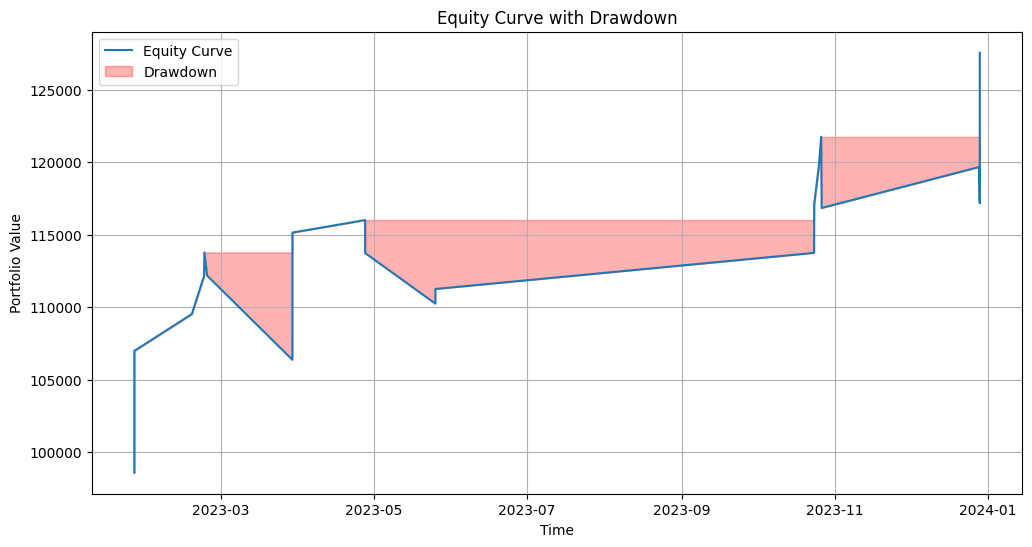

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['exit_time'], df['equity_curve'], label='Equity Curve')
plt.fill_between(df['exit_time'], df['rolling_max'], df['equity_curve'], color='red', alpha=0.3, label='Drawdown')
plt.legend()
plt.title("Equity Curve with Drawdown")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid()
plt.show()
